# Shopee Product Classification 

Notebook to experiment over several Neural Networks over the product dataset obtained from Shopee and evaluate results.

The following models are evaluated as part of this notebook:

Baseline 1: CNN <br>
Baseline 2: CNN with augmented layers <br>
Improvement 1: Adding ANN <br>
Improvement 2: Adding RNN <br>

## Imports and Config

In [63]:
!pip install scikit-image
!pip install shopee_crawler
!pip install torchvision
!pip install opencv-python

You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import sys
import json
import importlib
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils import file_utils, dataset
from scripts import crawler

import ipywidgets as widgets

In [2]:
# Can use this to reload file when editing for faster changes
importlib.reload(dataset)

<module 'utils.dataset' from 'C:\\Users\\shubh\\Desktop\\NUS\\Semester Two\\Neural Networks I\\cs5242-project\\utils\\dataset.py'>

## Data Load

In [3]:
image_dir = 'data/images'

In [10]:
if(file_utils.check_images_dir()):
    print(f'Images already exist at: {file_utils.images}')
elif(file_utils.check_tar_exists()):
    print(f'Images not yet extracted')
    print(f'Image zip exists at: {file_utils.images_zip}')
    file_utils.extract_tar()
else:
    print(f'Images need to be downloaded')
    for c in category_urls:
        get_category_data('data', c)
    download_images('data')

Images already exist at: data/images


## Note: To be in accordance with other folders, changes to make:
- Add "-cat" to Women's Apparel directory after unzipping (Maybe we handle when we're zipping itself? Otherwise we can add a condition for this in the dataloader too)

## Dataset

In [5]:
data = dataset.DataSet()

<BarContainer object of 27 artists>

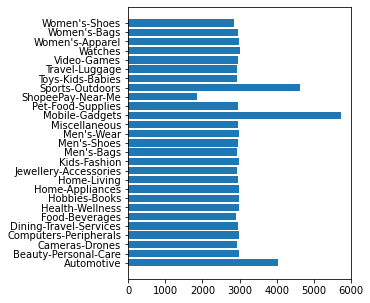

In [6]:
cats, items = zip(*data.image_count_per_category().items())
fig, ax = plt.subplots(figsize=(4, 5))
ax.barh(cats, items)

In [7]:
data.load_all()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73865/73865 [04:47<00:00, 256.61it/s]


In [18]:
all_categories = data.categories
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: data.plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('Automotive', 'Beauty-Personal-Care', 'Cameras…

In [7]:
#TODO: Check if need to normalize data or convert shapes